In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import copy
from skimage.transform import radon, iradon
from math import floor
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.axes_grid1 import ImageGrid

import gvxrPython3 as gvxr
import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux


Define constants for this experiment

In [2]:
number_of_projections = 3200;
angular_step = 180 / number_of_projections;

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [3]:
json2gvxr.initGVXR("notebook-9.json", "OPENGL")

Create an OpenGL context: 512x512
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 512 512


## X-ray source

We create an X-ray source. It is a parallel source.

In [4]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


## Spectrum

The spectrum is monochromatic.

In [5]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)

## Detector

Create a digital detector

In [6]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [150, 150]
	Pixel spacing: [0.5, 0.5, 'cm']
INIT RENDER


## Scanned object

We create a cylinder. Its linear attenuation coefficient is 0.5 cm<sup>-1</sup>. The cylinder is within  a cube whose linear attenuation coefficient is 0.1 cm<sup>-1</sup>.

In [7]:
json2gvxr.initSamples("notebook-9.json", verbose=1)

Load the 3D data

Cube is a cube
Cylinder is a cylinder


## Runing the simulation

Update the 3D visualisation and take a screenshot

In [8]:
gvxr.displayScene()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1837.098388671875)
gvxr.setSceneRotationMatrix([0.48896607756614685, 0.2033134251832962, -0.8482770919799805, 0.0, -0.8596474528312683, 0.2773565351963043, -0.4290446639060974, 0.0, 0.14804469048976898, 0.9390085339546204, 0.3103960156440735, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

0 0 500 500
0 0 512 512


In [9]:
screenshot = gvxr.takeScreenshot()

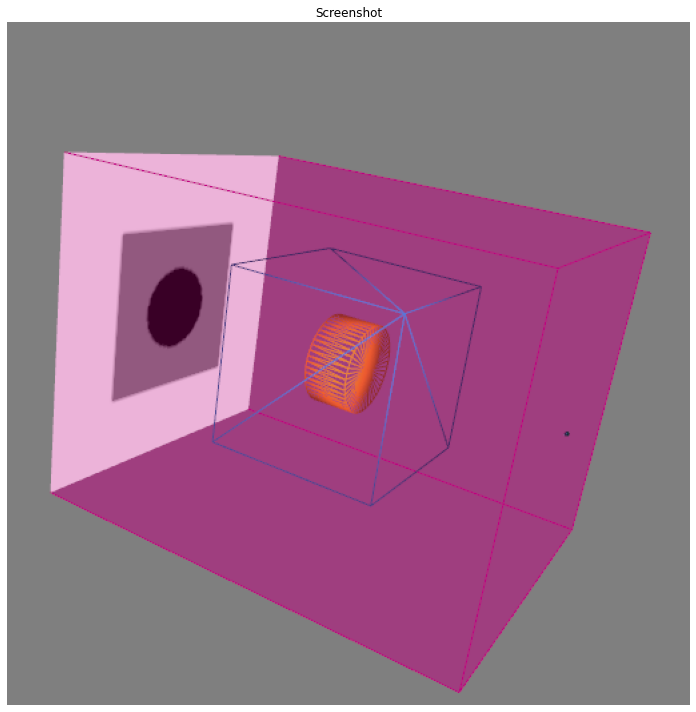

In [10]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-simple_CT.pdf')
plt.savefig('plots/screenshot-beam-off-simple_CT.png')

Update set of projections while rotating the scene to mimick CT acquisition

In [11]:
raw_projections = [];
theta = [];

for angle_id in range(0, number_of_projections):

    # Add the rotation angle, starting from 0
    theta.append(-angular_step * angle_id)
    
    # Compute an X-ray image    
    xray_image = np.array(gvxr.computeXRayImage());
    
    # Add to the set of projections
    raw_projections.append(xray_image)
    
    # Update the rendering
    gvxr.displayScene();

    # Rotate the sample
    gvxr.rotateScene(-angular_step, 0, 0, 1);

# Convert to numpy arrays
raw_projections = np.array(raw_projections)

Perform flat-field correction

In [12]:
# Create a mock dark field image
dark_field_image = np.zeros(raw_projections.shape);

# Create a mock flat field image
flat_field_image = np.ones(raw_projections.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("MeV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
corrected_projections = (raw_projections - dark_field_image) / (flat_field_image - dark_field_image)

In [13]:
print(corrected_projections.min(), corrected_projections.max())

1.74154490280235e-06 1.0


Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [14]:
# Create a temporary image to hold the sinogram
minus_log_projs = copy.deepcopy(corrected_projections);
    
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
minus_log_projs[minus_log_projs < threshold] = threshold;

# Apply the minus log normalisation
minus_log_projs = -np.log(minus_log_projs);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Reofrmat the projections into a set of sinograms
sinograms = np.swapaxes(minus_log_projs, 0, 1); 

In [15]:
print(sinograms.shape)

(150, 3200, 150)


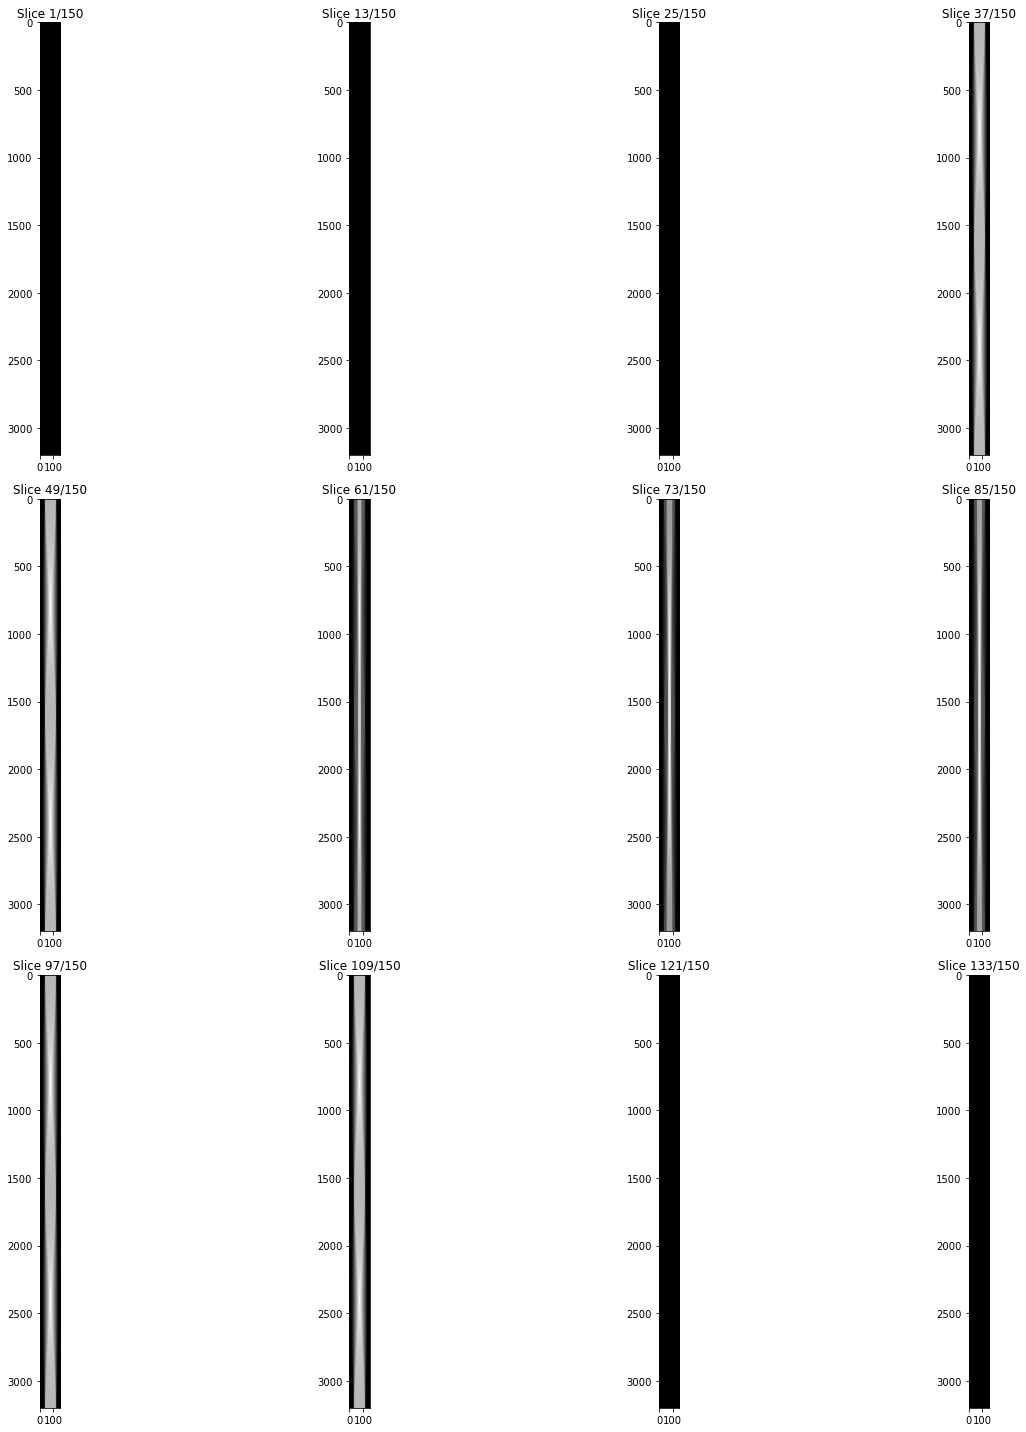

In [16]:
ncols = 4
nrows = 3

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)


fig = plt.figure(figsize= (20,20))
# # plt.title("Detector response")
# plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
# plt.xlabel('Incident energy: E (in keV)')
# plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

# f, axarr = plt.subplots(5, 5)

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id], cmap='gray')
        
plt.tight_layout()

Find the rotation axis

In [17]:
# rot_center = tomopy.find_center(sinograms, theta, init=290, ind=0, tol=0.5)

Reconstruct the CT slice

In [18]:
CT_volume = []

for sinogram in sinograms:
    CT_volume.append(iradon(sinogram.T, theta=theta, circle=True))

# plt.imshow(CT, cmap='gray');
# print(CT.max())
# CT_slice_from_simulated_sinogram = [];
   
# #Lets reconstruct the centre slice
# slice = len(simulated_sinogram) / 2;

# print("reconstructing slice # ", slice);
# CT_slice_from_simulated_sinogram.append(iradon(simulated_sinogram[slice].T, theta=theta, circle=True));
       
# # Save the CT slice
# CT_slice_from_simulated_sinogram = np.array(CT_slice_from_simulated_sinogram);
    
    
    
# volume = sitk.GetImageFromArray(CT_slice_from_simulated_sinogram);
# volume.SetSpacing([0.625, 0.625, 0.7]);
# sitk.WriteImage(volume, "recon_in_MU.mha", useCompression=True);


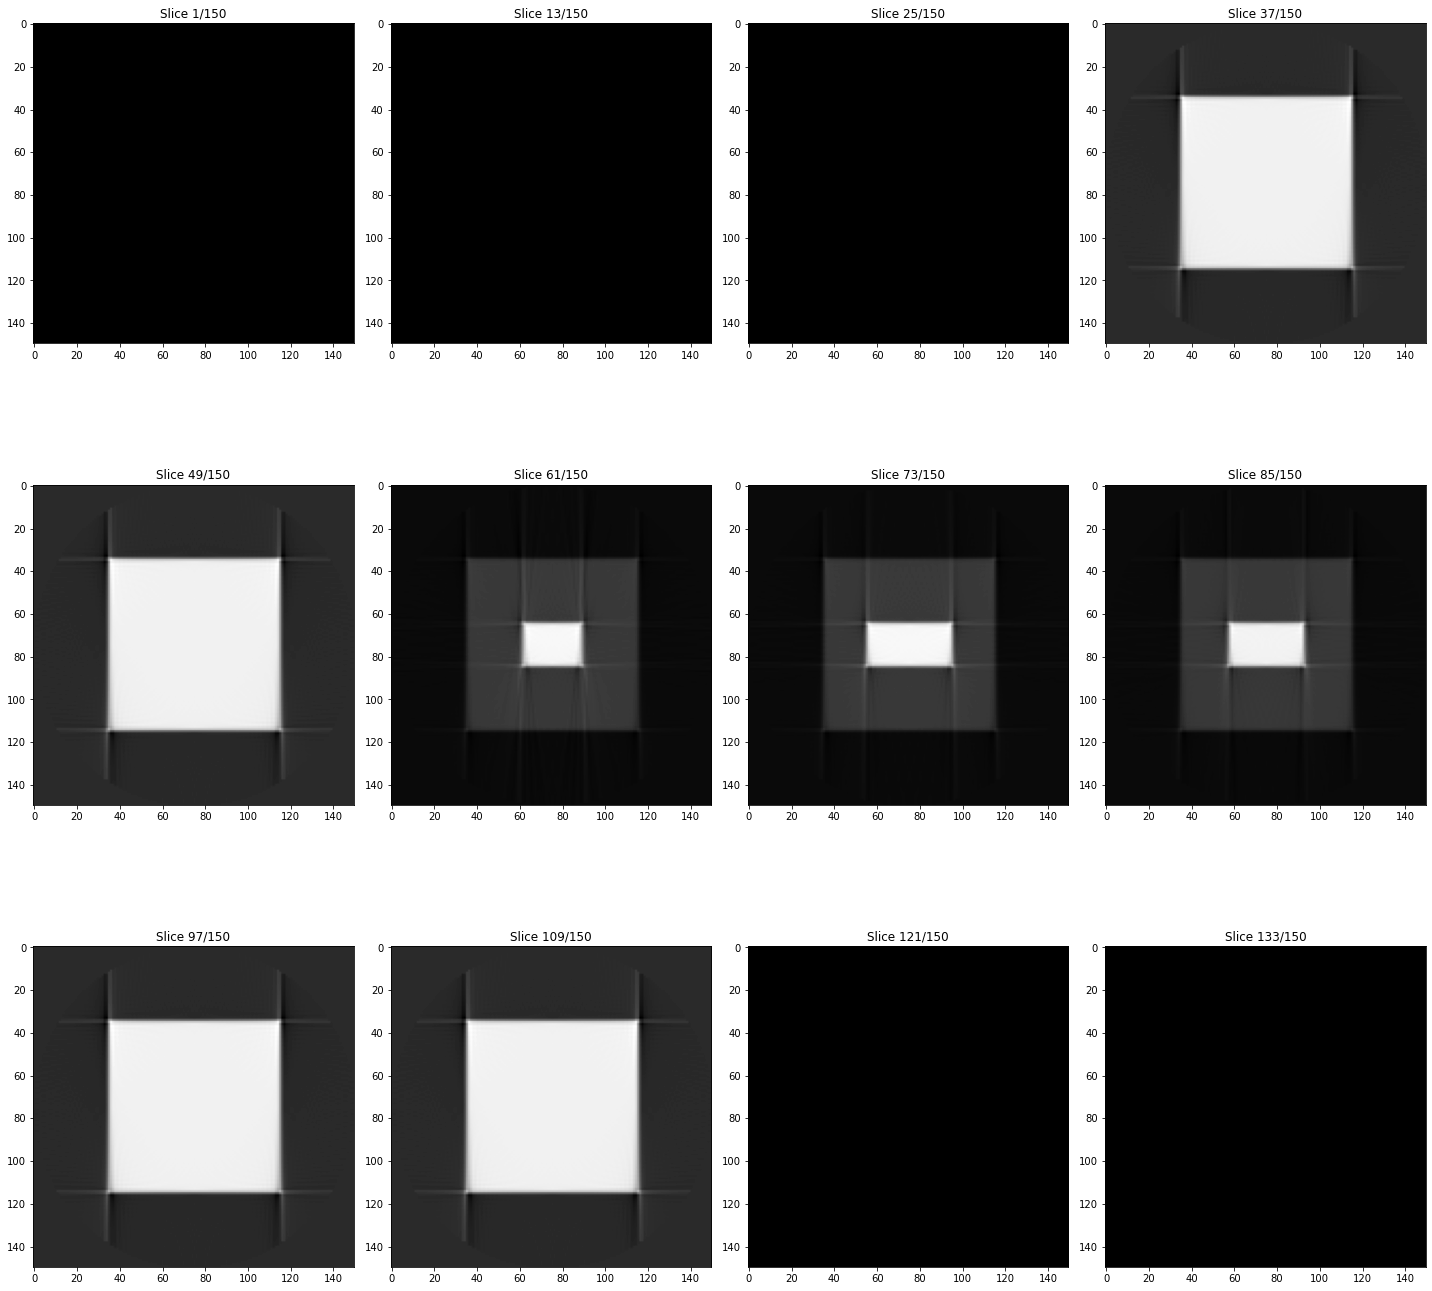

In [19]:
ncols = 4
nrows = 3

step = int(len(CT_volume) / (ncols * nrows))
slices = range(0, int(len(CT_volume)), step)

fig = plt.figure(figsize= (20,20))
# # plt.title("Detector response")
# plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
# plt.xlabel('Incident energy: E (in keV)')
# plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

# f, axarr = plt.subplots(5, 5)

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(len(CT_volume)))
        ax.imshow(CT_volume[slice_id], cmap='gray')
        
plt.tight_layout()